Predictions saved → prediction_result.csv

=== Evaluation on NEW CLAIMS (30 rows) ===

Accuracy: 0.9000

=== Classification Report ===
              precision    recall  f1-score   support

        HIGH       1.00      0.50      0.67         4
      MEDIUM       0.80      1.00      0.89        12
      NORMAL       1.00      0.93      0.96        14

    accuracy                           0.90        30
   macro avg       0.93      0.81      0.84        30
weighted avg       0.92      0.90      0.89        30

=== Confusion Matrix ===
[[ 2  2  0]
 [ 0 12  0]
 [ 0  1 13]]


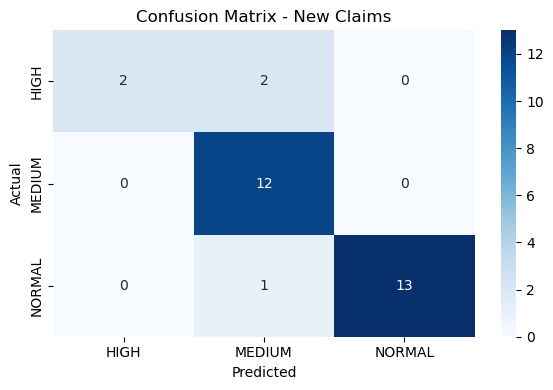

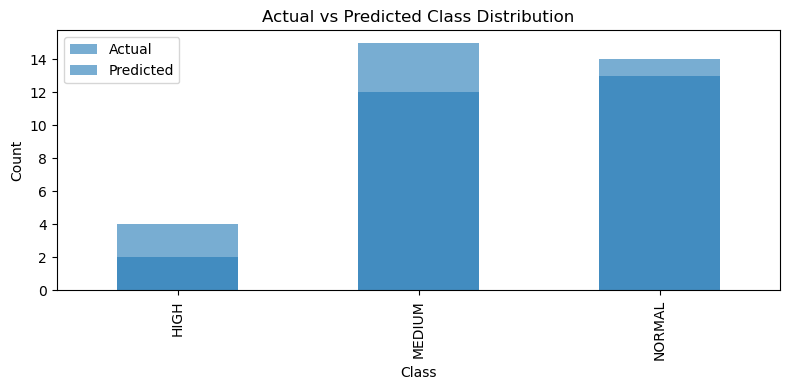

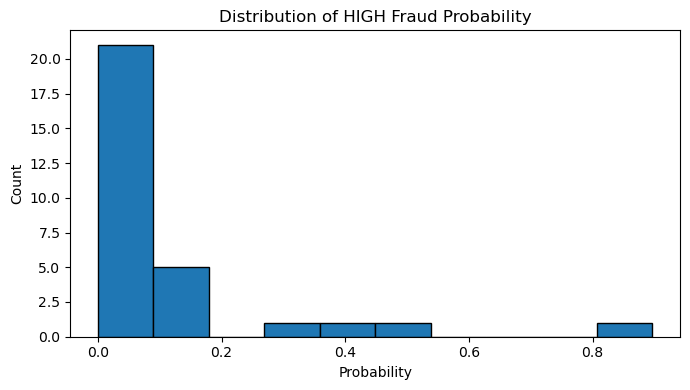

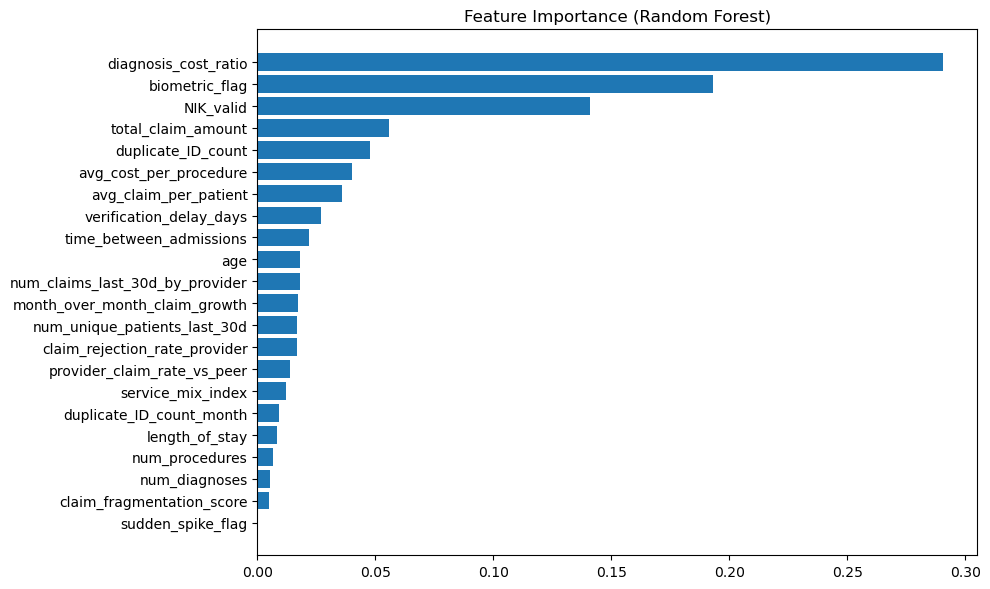

In [ ]:
import pandas as pd
import joblib
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Load model ===
model = joblib.load("fraud_model.pkl")

# === 2. Load new claims ===
df_new = pd.read_csv("new_claims_30.csv", dtype={"NIK": str})

# Convert tanggal → datetime wajib
df_new['claim_date'] = pd.to_datetime(df_new['claim_date'])
df_new['service_date'] = pd.to_datetime(df_new['service_date'])
# === 3. Ensure same features ===
features = [
    'age','NIK_valid','biometric_flag','num_diagnoses','num_procedures',
    'length_of_stay','total_claim_amount','diagnosis_cost_ratio',
    'avg_cost_per_procedure','verification_delay_days',
    'duplicate_ID_count','duplicate_ID_count_month','time_between_admissions',
    'num_claims_last_30d_by_provider','num_unique_patients_last_30d',
    'provider_claim_rate_vs_peer','claim_rejection_rate_provider',
    'month_over_month_claim_growth','sudden_spike_flag',
    'avg_claim_per_patient','claim_fragmentation_score','service_mix_index'
]

X_new = df_new[features]
y_true = df_new["fraud_label"]

# === 4. Predict ===
y_pred = model.predict(X_new)
df_new["predicted_label"] = y_pred

# Prob HIGH
df_new["fraud_prob_HIGH"] = model.predict_proba(X_new)[:, 0]

# === 5. Save ===
df_new.to_csv("prediction_result.csv", index=False)
print("Predictions saved → prediction_result.csv")

# === 6. Evaluation ===
print("\n=== Evaluation on NEW CLAIMS (30 rows) ===")
acc = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {acc:.4f}")

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred))

print("=== Confusion Matrix ===")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# ================================
# === 7. VISUALIZATIONS ==========
# ================================

# --- 7.1 Confusion Matrix (Heatmap) ---
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["HIGH","MEDIUM","NORMAL"],
            yticklabels=["HIGH","MEDIUM","NORMAL"])
plt.title("Confusion Matrix - New Claims")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 7.2 Predicted vs Actual Bar Chart ---
plt.figure(figsize=(8,4))
df_new["fraud_label"].value_counts().sort_index().plot(kind='bar', alpha=0.6, label='Actual')
df_new["predicted_label"].value_counts().sort_index().plot(kind='bar', alpha=0.6, label='Predicted')
plt.title("Actual vs Predicted Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

# --- 7.3 Probability distribution for HIGH Fraud ---
plt.figure(figsize=(7,4))
plt.hist(df_new["fraud_prob_HIGH"], bins=10, edgecolor='black')
plt.title("Distribution of HIGH Fraud Probability")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# --- 7.4 Feature Importance (dari model RF) ---
import numpy as np

plt.figure(figsize=(10,6))
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.barh([features[i] for i in indices], importances[indices])
plt.title("Feature Importance (Random Forest)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


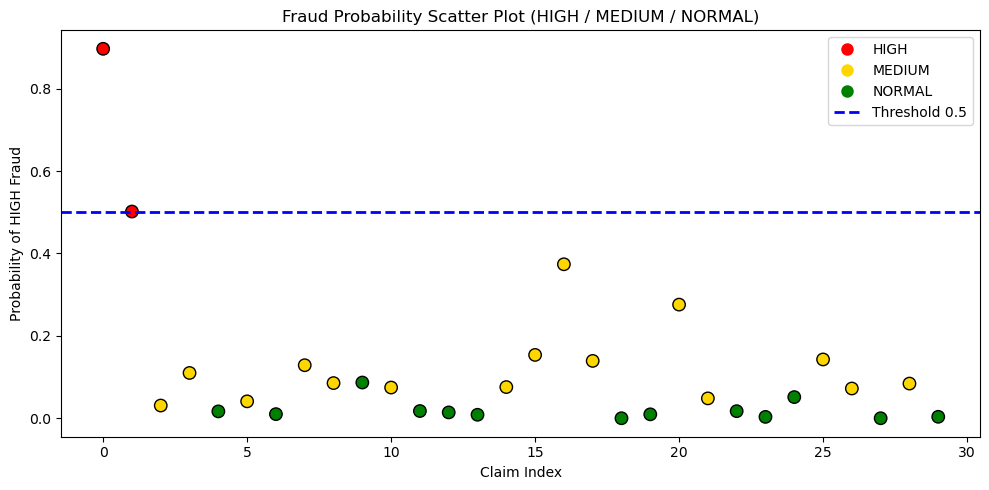

In [2]:
import matplotlib.pyplot as plt

# Gunakan dataframe df_new yang sudah berisi:
# - fraud_prob_HIGH
# - fraud_label
# - predicted_label

# Warna berdasarkan kelas
color_map = {
    "HIGH": "red",
    "MEDIUM": "gold",
    "NORMAL": "green"
}

# Generate warna titik
colors = df_new["predicted_label"].map(color_map)

plt.figure(figsize=(10,5))

# Scatter plot prob vs index
plt.scatter(df_new.index, df_new["fraud_prob_HIGH"], 
            c=colors, s=80, edgecolor='black')

# Garis threshold tengah
threshold = 0.5
plt.axhline(y=threshold, color='blue', linestyle='--', linewidth=2, label="Threshold 0.5")

# Label
plt.title("Fraud Probability Scatter Plot (HIGH / MEDIUM / NORMAL)")
plt.xlabel("Claim Index")
plt.ylabel("Probability of HIGH Fraud")

# Legend custom
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='HIGH', markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='MEDIUM', markerfacecolor='gold', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='NORMAL', markerfacecolor='green', markersize=10),
    Line2D([0], [0], color='blue', lw=2, linestyle='--', label='Threshold 0.5')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()
